原文章中Fig2和Fig3的图基本一样，分别是选取SE和A3SS的数据

In [ ]:
library("tidyverse")
library("GOplot")
library("clusterProfiler")
library("org.Hs.eg.db")
library("AnnotationHub")

# A. GO enrichment analysis of genes harboring significant AS events


## 1. prepare data


In [240]:
dir = "results/rMATs/sig"
rmats_df = list()
for (file in dir("results/rMATs/sig")) {
   rmats = read.table(paste0(dir, "/", file), header = T, sep = "\t")
    rmats_df[[file]] = rmats
}
# combine gain and loss file of the same AS type, like A3SS.sig.gain.txt and A3SS.sig.lose.txt
AS_type = c("A3SS", "A5SS", "MXE", "RI", "SE")
for (i in 1:length(AS_type)) {
    rmats_df[[paste0(AS_type[i])]] = rbind(rmats_df[[paste0(AS_type[i], ".sig.gain.txt")]], rmats_df[[paste0(AS_type[i], ".sig.lose.txt")]])
}
# drop elements end with .txt
rmats_df = rmats_df[!grepl(".txt", names(rmats_df))]
gene_list = list()
for (i in 1:length(AS_type)) {
    gene_list[[paste0(AS_type[i])]] = rmats_df[[paste0(AS_type[i])]] %>% dplyr::select(c("GeneID", "geneSymbol","IncLevelDifference"))
    # add new column of AS type
    gene_list[[paste0(AS_type[i])]] = cbind(gene_list[[paste0(AS_type[i])]], AS_type[i])
}
# rbind all AS type
gene_dat = do.call(rbind, gene_list) %>% rename("AS_type[i]" = "AS_type")

In [243]:
# select AS type
gene_dat = gene_dat %>% filter(AS_type == "SE")

## 2. clusterProfiler


In [ ]:
go_list = list()
for (ont in c("BP", "CC", "MF")) {
    go_list[[ont]] = enrichGO(gene = gene_dat$GeneID, 
                              OrgDb = org.Hs.eg.db, 
                              keyType = "ENSEMBL",
                              ont = ont, 
                              pAdjustMethod = "BH", 
                              pvalueCutoff = 0.05, 
                            #   qvalueCutoff = 0.05, 
                              readable = T)
}
go_list

按照默认参数(pvalueCutoff = 0.05, qvalueCutoff = 0.2)，只有 MF 有两个 GO term，其他都没有。调整为 pvalueCutoff = 0.5, qvalueCutoff = 0.5，结果如下：


In [244]:
go_list = list()
for (ont in c("BP", "CC", "MF")) {
    go_list[[ont]] = enrichGO(gene = gene_dat$GeneID, 
                              OrgDb = org.Hs.eg.db, 
                              keyType = "ENSEMBL",
                              ont = ont, 
                              pAdjustMethod = "BH", 
                              pvalueCutoff = 0.5, 
                              qvalueCutoff = 0.5, 
                              readable = T)
}
go_list

$BP
#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:24] "ENSG00000126453" "ENSG00000088448" "ENSG00000250571" ...
#...pvalues adjusted by 'BH' with cutoff <0.5 
#...352 enriched terms found
'data.frame':	352 obs. of  9 variables:
 $ ID         : chr  "GO:0006977" "GO:0031571" "GO:0044819" "GO:0043281" ...
 $ Description: chr  "DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest" "mitotic G1 DNA damage checkpoint signaling" "mitotic G1/S transition checkpoint signaling" "regulation of cysteine-type endopeptidase activity involved in apoptotic process" ...
 $ GeneRatio  : chr  "2/18" "2/18" "2/18" "3/18" ...
 $ BgRatio    : chr  "18/21261" "29/21261" "29/21261" "189/21261" ...
 $ pvalue     : num  0.000103 0.000271 0.000271 0.000511 0.000893 ...
 $ p.adjust   : num  0.0318 0.0318 0.0318 0.045 0.0629 ...
 $ qvalue     : num  0.0216 0.0216 0.0216 0.0305 0.0427 ...
 $ geneID

'select()' returned 1:1 mapping between keys and columns



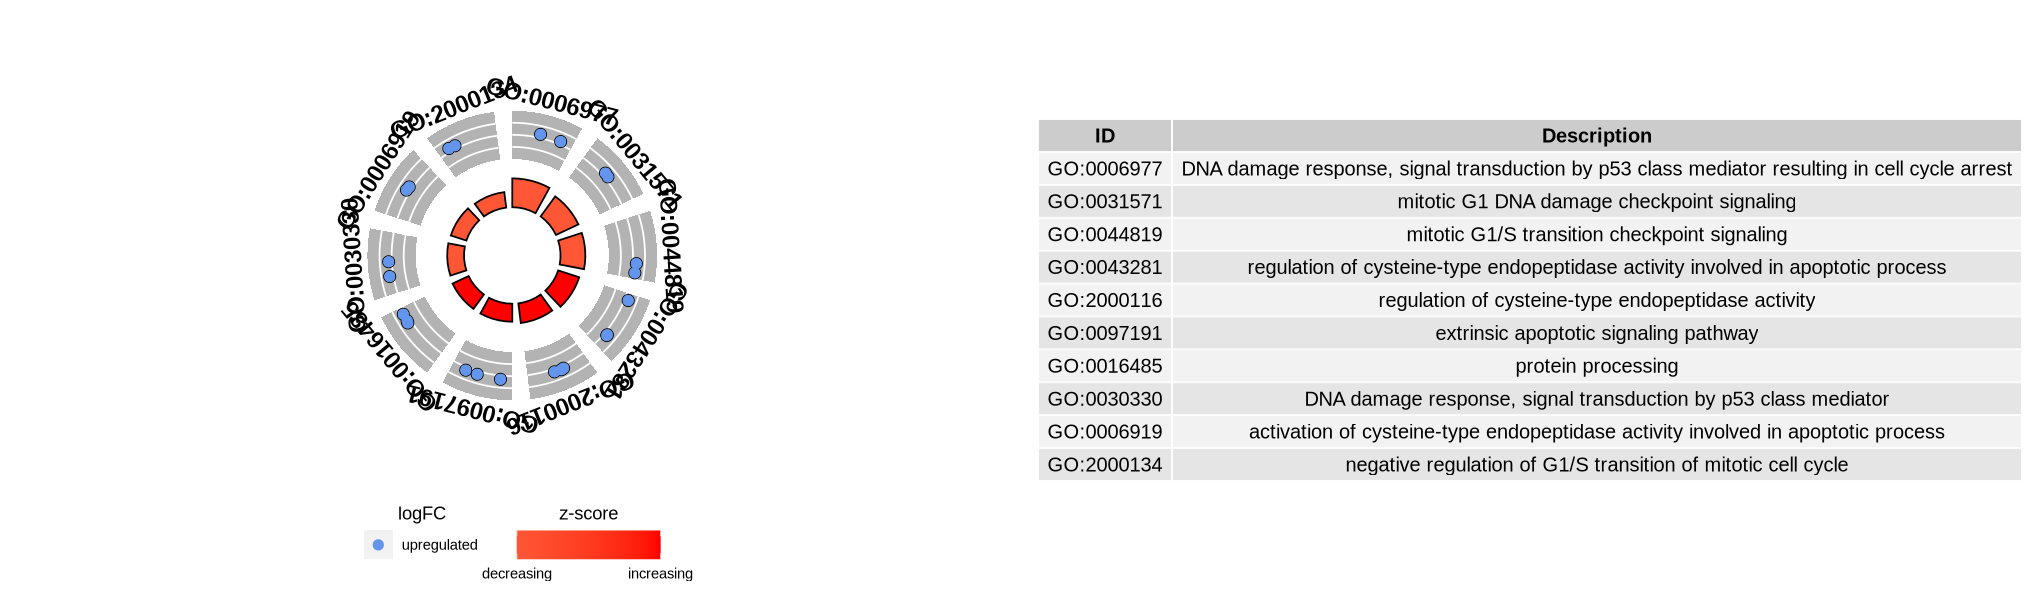

In [246]:
# genes = A data frame with columns for 'ID', 'logFC' selected from rmat_df
# rename GeneID to ID, IncLevelDifference to logFC in gene_dat
gene_list_sel = gene_dat %>% dplyr::select(c("GeneID", "IncLevelDifference"))
# unique based on GeneID, only keep the first one
gene_list_sel = gene_list_sel[!duplicated(gene_list_sel$GeneID),]
colnames(gene_list_sel) = c("ID", "logFC")
gene_list_sel$ID = bitr(gene_list_sel$ID, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db, drop = F)[,2]
modify_terms = function(terms, ont) {
    terms = as_tibble(terms)
    # add column to terms, fill with ont, column name is genes
    terms = cbind(terms, Category = rep(ont, nrow(terms)))
    colnames(terms)[colnames(terms) == "Description"] = "Term"
    colnames(terms)[colnames(terms) == "geneID"] = "Genes"
    colnames(terms)[colnames(terms) == "pvalue"] = "adj_pval"
    # replace "/" with ", " in term$genes
    terms$Genes = gsub("/", ", ", terms$Genes)
    return(terms)
}
# convert go_list to list
go_list_all = list(go_list$BP, go_list$CC, go_list$MF)
# repete gene_list_sel 3 times to a list
terms_all = pmap(list(terms = go_list_all, ont = c("BP", "CC", "MF")), modify_terms)
terms_all = do.call(rbind, terms_all)
circ_res = circle_dat(terms_all, gene_list_sel)
options(repr.plot.width=17, repr.plot.height=5)
GOCircle(circ_res)

B. Cnetplot

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(edge = your_value)' instead of 'colorEdge'.
 The colorEdge parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


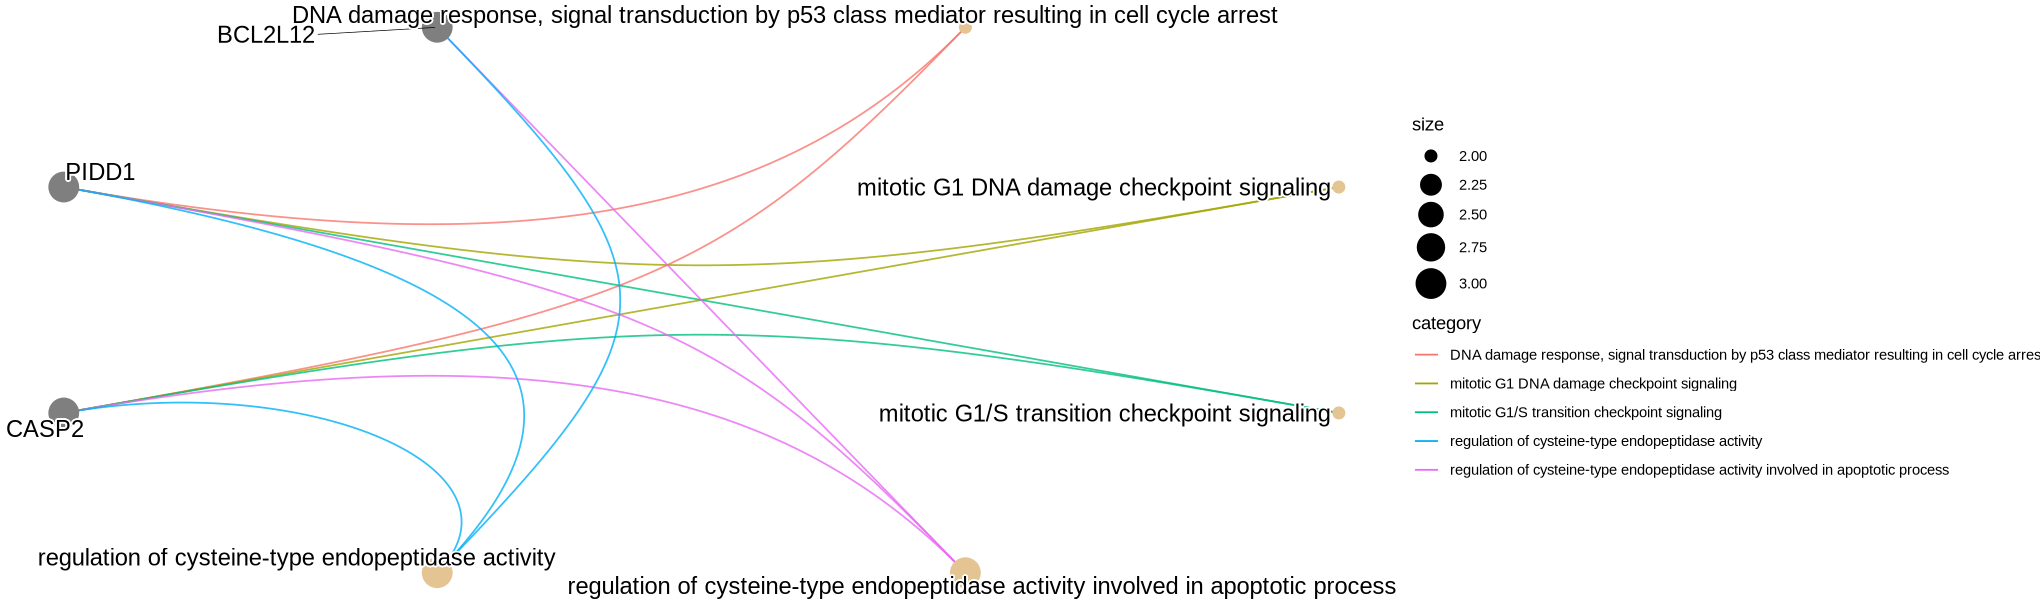

In [247]:
# make gene_list_sel$logFC as factor, the names of the factor are the gene_list_sel$ID
gene_list_factor = gene_list_sel$logFC %>% factor(.,levels = gene_list_sel$ID)
cnetplot(go_list$BP,foldChange=gene_list_factor, circular = TRUE, colorEdge = TRUE)

# C and D. Sashimi plot
```bash
rmats2sashimiplot \
    --b1 "$sampleMetaPD" \
    --b2 "$sampleMetaCC" \
    --gtf "$genome_gtf" \
    --l1 PD \
    --l2 CC \
    --exon_s 1 \
    --intron_s 5 \
    -o $rmats_outdir/sashimiplot
``````